# IMPORT STATEMENTS

In [1]:
!TMPDIR=/home/mgill/ pip install --cache-dir=/home/mgill/ --build /home/mgill/ pandas numpy sklearn xgboost matplotlib tensorflow==2.1.0 keras==2.2.4 fastai python-dateutil scikit-optimize scikit-learn==0.21 graphviz

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from math import sqrt
from statistics import mean
from sklearn.metrics import mean_squared_error, r2_score
import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
import pickle
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.impute import SimpleImputer

2.1.0


Using TensorFlow backend.


2.2.4


In [3]:
def new_prep_data(tt_file, ho_file):
    imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
    my_list = []
    x = 0 
    for chunk in pd.read_csv(tt_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            tt_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(tt_pheno.shape)
            tt_pheno = np.reshape(tt_pheno,(len(tt_pheno),1))
            print(tt_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    tt_vcf = pd.concat(my_list, axis = 1)
    my_list = []
    x=0
    for chunk in pd.read_csv(ho_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            ho_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(ho_pheno.shape)
            ho_pheno = np.reshape(ho_pheno,(len(ho_pheno),1))
            print(ho_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    ho_vcf = pd.concat(my_list, axis = 1)
    print(tt_vcf.shape)
    print(ho_vcf.shape)
    print(tt_pheno.shape)
            
    return tt_vcf, ho_vcf, tt_pheno, ho_pheno

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("PoC_Merged_filtered.csv_train_testQTL_SNPS.csv", "PoC_Merged_filtered.csv_holdoutQTL_SNPS.csv")
r_t = tt_pheno.ravel()
r_h = ho_pheno.ravel()
print(r_t[10])
i = 0
for x in r_t:
    if(x==0.5):
        r_t[i]=2.0
    i = i+1
i = 0
for x in r_h:
    if(x==0.5):
        r_h[i]=2.0
    i = i+1
r_t = np.reshape(r_t,(len(r_t),1))
r_h = np.reshape(r_h,(len(r_h),1))
tt_pheno = r_t
ho_pheno = r_h
print(tt_pheno.shape)
print(ho_pheno.shape)

10000
20000
30000
40000
50000
(617,)
(617, 1)
60000
10000
20000
30000
40000
50000
(155,)
(155, 1)
60000
(617, 58574)
(155, 58574)
(617, 1)
0.0
(617, 1)
(155, 1)


In [5]:
#if it hasn't been run and saved before
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe = ohe.fit(tt_vcf)

In [6]:
pickle.dump(ohe, open("PoC_QTL_ohe.dat", "wb"))

In [7]:
#if need or have new holdout data etc.
ohe = pickle.load(open("PoC_QTL_ohe.dat", "rb"))

In [8]:
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(617, 58574)
(617, 170396)
(155, 58574)
(155, 170396)


In [4]:
def find_snp_from_header(ohe,snp_num):
    count = 0
    snp = "Not found"
    found = False
    i = 0
    while i < len(ohe.categories_) and (found == False):
        j = 0
        while j < len(ohe.categories_[i]):
            if(count == snp_num):
                snp = ohe.categories_[i][j]
                found = True
                break
            count = count + 1
            j = j + 1
        i = i + 1
    return snp

In [10]:
## TESTING IF IT WORKS
my_snp = find_snp_from_header(ohe, 62793)
print(my_snp)

C/C


# XGBOOST ML Model

In [11]:
##ONLY NEED TO DO IF OPTIMISING

print(tt_vcf.shape)
print(tt_pheno.shape)
seed = randint(0,5000)
X_train, X_test, y_train, y_test = train_test_split(tt_vcf, tt_pheno, test_size=0.2, random_state=seed)
print(X_test.shape)
print("seed is " + str(seed))

(617, 170396)
(617, 1)
(124, 170396)
seed is 3336


In [12]:
space ={'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'max_depth': Integer(0, 50),
        'max_delta_step': Integer(0, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(0, 5),
        'n_estimators': Integer(50, 200),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}

In [13]:
def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = xgb_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

In [14]:
xgbcl = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
xgb_bayes_search = BayesSearchCV(xgbcl, space, n_iter=32, # specify how many iterations
                                    scoring=None, n_jobs=1, cv=5, verbose=3, random_state=42, n_points=12,
                                 refit=True)
xgb_bayes_search.fit(X_train, y_train.ravel(), callback = on_step)
print(xgb_bayes_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:15:37] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:15:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.880, total=  44.2s
[CV] colsample_bylevel=0.416002919

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.2s remaining:    0.0s


[09:16:21] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:16:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.818, total=  41.3s
[CV] colsample_bylevel=0.416002919

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[09:17:03] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:17:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.828, total=  40.8s
[CV] colsample_bylevel=0.416002919

[09:21:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.18630307921210337, colsample_bytree=0.6357746718688816, gamma=4.759632988007942e-09, learning_rate=0.21560448660617149, max_delta_step=14, max_depth=39, min_child_weight=0, n_estimators=198, reg_alpha=1.307103676304351e-05, reg_lambda=1.1326211354138217e-09, scale_pos_weight=22.356393886375308, subsample=0.7121579996266859, score=0.837, total=  51.9s
[CV] colsample_bylevel=0.18630307921210337, colsample_bytree=0.6357746718688816, gamma=4.759632988007942e-09, learning_rate=0.21560448660617149, max_delta_step=14, max_depth=39, min_child_weight=0, n_estimators=198, reg_alpha=1.307103676304351e-05, reg_lambda=1.1326211354138217e-09, scale_pos_weight=22.356393886375308, subsample=0.7121579996266859 
[09:22:36] WARNIN

[09:25:26] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:25:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.7711308526006485, colsample_bytree=0.07988300914246868, gamma=1.3877597085692663e-08, learning_rate=0.15021004353467043, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=77, reg_alpha=0.006097622112520179, reg_lambda=1.9368851099909265e-09, scale_pos_weight=6.97020795804701e-06, subsample=0.46717487628832827, score=0.890, total=  11.1s
[CV] colsample_bylevel=0.7711308

[09:27:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.9132100359267209, colsample_bytree=0.7679711803126804, gamma=2.428808912219129e-07, learning_rate=0.03511167856740689, max_delta_step=3, max_depth=8, min_child_weight=4, n_estimators=197, reg_alpha=0.023358352781682152, reg_lambda=2.1396512525873352e-07, scale_pos_weight=0.001760608876847004, subsample=0.15990388740095085, score=0.798, total= 1.0min
[CV] colsample_bylevel=0.9132100359267209, colsample_bytree=0.7679711803126804, gamma=2.428808912219129e-07, learning_rate=0.03511167856740689, max_delta_step=3, max_depth=8, min_child_weight=4, n_estimators=197, reg_alpha=0.023358352781682152, reg_lambda=2.1396512525873352e-07, scale_pos_weight=0.001760608876847004, subsample=0.15990388740095085 
[09:28:22] WARNING:

[09:31:54] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:31:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, scale_pos_weight=0.4420166988445819, subsample=0.037978567417966985, score=0.612, total=  10.9s
[CV] colsample_bylevel=0.356907918073

[CV]  colsample_bylevel=0.3173884684879576, colsample_bytree=0.9154083808190769, gamma=0.37957777315906627, learning_rate=0.046564465205051725, max_delta_step=5, max_depth=25, min_child_weight=4, n_estimators=98, reg_alpha=1.8932210348902655e-05, reg_lambda=10.393593598030753, scale_pos_weight=0.019183460268621746, subsample=0.6299477217301774, score=0.876, total=  32.4s
[CV] colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868 
[09:34:54] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  ve

[09:37:42] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:37:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.06936552953088004, colsample_bytree=0.5708703891954323, gamma=1.9956389638103137e-08, learning_rate=0.09010297955022104, max_delta_step=9, max_depth=25, min_child_weight=2, n_estimators=139, reg_alpha=0.9824119669778386, reg_lambda=0.00017577858139476563, scale_pos_weight=261.4450653749918, subsample=0.14242164035537377, score=0.828, total=  21.0s
[CV] colsample_bylevel=0.0693655295

[09:39:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.1798648261515349, colsample_bytree=0.1536154650973617, gamma=2.692171045057089e-07, learning_rate=0.031045751168128115, max_delta_step=12, max_depth=24, min_child_weight=3, n_estimators=113, reg_alpha=0.0011518554964803237, reg_lambda=3.9270934206560135e-05, scale_pos_weight=0.036328353682153036, subsample=0.5123744729843144, score=0.848, total=  17.9s
[CV] colsample_bylevel=0.1798648261515349, colsample_bytree=0.1536154650973617, gamma=2.692171045057089e-07, learning_rate=0.031045751168128115, max_delta_step=12, max_depth=24, min_child_weight=3, n_estimators=113, reg_alpha=0.0011518554964803237, reg_lambda=3.9270934206560135e-05, scale_pos_weight=0.036328353682153036, subsample=0.5123744729843144 
[09:40:08] WA

[09:43:06] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:43:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, scale_pos_weight=5.68219069233494e-06, subsample=0.3682037565911086, score=0.845, total=  35.6s
[CV] colsample_bylevel=0.885427980014

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 30.7min finished


best score: 0.8681541582150102
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.07385324490376632, max_delta_step=12, max_depth=0, min_child_weight=5, n_estimators=67, reg_alpha=1.0, reg_lambda=5.023273816526789e-08, scale_pos_weight=1e-06, subsample=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:46:25] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:46:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.07385324490376632, max_delta_step=12, max_depth=0, min_child_weight=5, n_estimators=67, reg_alpha=1.0, reg_lambda=5.023273816526789e-08, scale_pos_weight=1e-06, subsample=1.0, score=0.580, total=  11.2s
[CV] colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.07385324490376632, max_delta_step=12, max_depth

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[09:46:36] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:46:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.07385324490376632, max_delta_step=12, max_depth=0, min_child_weight=5, n_estimators=67, reg_alpha=1.0, reg_lambda=5.023273816526789e-08, scale_pos_weight=1e-06, subsample=1.0, score=0.586, total=   9.9s
[CV] colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.07385324490376632, max_delta_step=12, max_depth

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s


[09:46:46] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:46:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.07385324490376632, max_delta_step=12, max_depth=0, min_child_weight=5, n_estimators=67, reg_alpha=1.0, reg_lambda=5.023273816526789e-08, scale_pos_weight=1e-06, subsample=1.0, score=0.586, total=  10.7s
[CV] colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.07385324490376632, max_delta_step=12, max_depth

[09:48:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.01, colsample_bytree=0.01, gamma=0.0004220541874780832, learning_rate=0.04600576240195131, max_delta_step=20, max_depth=17, min_child_weight=1, n_estimators=143, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=499.99999999999994, subsample=1.0, score=0.691, total=  16.0s
[CV] colsample_bylevel=1.0, colsample_bytree=0.9446923854635458, gamma=1e-09, learning_rate=0.09543696827179805, max_delta_step=20, max_depth=0, min_child_weight=5, n_estimators=50, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=0.6775813303897988 
[09:48:37] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[CV]  colsample_bylevel=0.01, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=20, max_depth=50, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=1.0, score=0.838, total=  14.2s
[CV] colsample_bylevel=0.01, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=20, max_depth=50, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=1.0 
[09:49:56] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:49:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. E

[09:51:23] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:51:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.01, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.2686464976410889, max_delta_step=20, max_depth=40, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=6.639786763923772e-08, scale_pos_weight=2.1407317883464803e-06, subsample=1.0, score=0.887, total=  10.8s
[CV] colsample_bylevel=0.01, colsample_bytree=0.16219460855181925, gamma=1e-09, learning_rate=0.07499764003328

[09:54:09] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:54:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.01, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.025687348390009163, max_delta_step=20, max_depth=50, min_child_weight=0, n_estimators=64, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=499.99999999999994, subsample=1.0, score=0.808, total=  20.6s
[CV] colsample_bylevel=0.01, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.025687348390009163, max_delta_step=20, max_de

[09:56:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.08655027472951894, max_delta_step=20, max_depth=50, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=0.5930002447690905, score=0.816, total=  24.8s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.08655027472951894, max_delta_step=20, max_depth=50, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=0.5930002447690905 
[09:57:15] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings b

[CV]  colsample_bylevel=0.01, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=20, max_depth=0, min_child_weight=0, n_estimators=200, reg_alpha=1e-09, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=1.0, score=0.580, total=  19.8s
[CV] colsample_bylevel=0.01, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=20, max_depth=0, min_child_weight=0, n_estimators=200, reg_alpha=1e-09, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=1.0 
[09:58:37] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:58:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[10:01:17] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:01:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.6756169052076102, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.01, max_delta_step=20, max_depth=0, min_child_weight=0, n_estimators=200, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=499.99999999999994, subsample=0.788354085349178, score=0.582, total=  25.8s
[CV] colsample_bylevel=0.6756169052076102, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.01, max_delta_ste

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 31.3min finished


best score: 0.8681541582150102
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] colsample_bylevel=0.7539856612396592, colsample_bytree=1.0, gamma=5.892350703005532e-07, learning_rate=0.08952178082527781, max_delta_step=1, max_depth=36, min_child_weight=1, n_estimators=106, reg_alpha=3.777875653000374e-08, reg_lambda=0.025468207657755936, scale_pos_weight=1.3834669532987018, subsample=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:17:49] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:17:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.7539856612396592, colsample_bytree=1.0, gamma=5.892350703005532e-07, learning_rate=0.08952178082527781, max_delta_step=1, max_depth=36, min_child_weight=1, n_estimators=106, reg_alpha=3.777875653000374e-08, reg_lambda=0.025468207657755936, scale_pos_weight=1.3834669532987018, subsample=1.0, score=0.900, total=  59.0s
[CV] colsample_bylevel=0.7539856612396592, colsample_bytree=1.0, g

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.0s remaining:    0.0s


[10:18:48] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:18:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.7539856612396592, colsample_bytree=1.0, gamma=5.892350703005532e-07, learning_rate=0.08952178082527781, max_delta_step=1, max_depth=36, min_child_weight=1, n_estimators=106, reg_alpha=3.777875653000374e-08, reg_lambda=0.025468207657755936, scale_pos_weight=1.3834669532987018, subsample=1.0, score=0.838, total=  59.1s
[CV] colsample_bylevel=0.7539856612396592, colsample_bytree=1.0, g

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[10:19:47] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:19:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.7539856612396592, colsample_bytree=1.0, gamma=5.892350703005532e-07, learning_rate=0.08952178082527781, max_delta_step=1, max_depth=36, min_child_weight=1, n_estimators=106, reg_alpha=3.777875653000374e-08, reg_lambda=0.025468207657755936, scale_pos_weight=1.3834669532987018, subsample=1.0, score=0.869, total= 1.0min
[CV] colsample_bylevel=0.7539856612396592, colsample_bytree=1.0, g

[CV]  colsample_bylevel=0.3288861044516802, colsample_bytree=0.5471941705860428, gamma=1.8725286198986933e-06, learning_rate=0.03593943082189275, max_delta_step=10, max_depth=19, min_child_weight=1, n_estimators=84, reg_alpha=2.609154014915572e-07, reg_lambda=157.06200136337932, scale_pos_weight=0.010093787540742112, subsample=0.6493425997136414, score=0.847, total=  28.3s
[CV] colsample_bylevel=0.3288861044516802, colsample_bytree=0.5471941705860428, gamma=1.8725286198986933e-06, learning_rate=0.03593943082189275, max_delta_step=10, max_depth=19, min_child_weight=1, n_estimators=84, reg_alpha=2.609154014915572e-07, reg_lambda=157.06200136337932, scale_pos_weight=0.010093787540742112, subsample=0.6493425997136414 
[10:24:37] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  ve

[10:26:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.30190692068544567, colsample_bytree=0.7993091105672656, gamma=5.330557652608038e-08, learning_rate=0.046594183737523644, max_delta_step=12, max_depth=28, min_child_weight=1, n_estimators=127, reg_alpha=8.67469405516486e-08, reg_lambda=0.1510489799379124, scale_pos_weight=0.016998104884807793, subsample=0.5972460475608784, score=0.910, total=  45.1s
[CV] colsample_bylevel=0.30190692068544567, colsample_bytree=0.7993091105672656, gamma=5.330557652608038e-08, learning_rate=0.046594183737523644, max_delta_step=12, max_depth=28, min_child_weight=1, n_estimators=127, reg_alpha=8.67469405516486e-08, reg_lambda=0.1510489799379124, scale_pos_weight=0.016998104884807793, subsample=0.5972460475608784 
[10:27:07] WARNING: .

[10:30:56] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:30:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=1.0, colsample_bytree=0.9512076537730382, gamma=0.00015405419782536298, learning_rate=0.9985313547288144, max_delta_step=17, max_depth=43, min_child_weight=0, n_estimators=69, reg_alpha=0.12392806740765744, reg_lambda=6.835623754460854e-05, scale_pos_weight=499.99999999999994, subsample=0.01, score=0.323, total=  15.9s
[CV] colsample_bylevel=1.0, colsample_bytree=0.9512076537730382, g

[CV]  colsample_bylevel=0.8143193811563679, colsample_bytree=0.3532780413721867, gamma=2.3998299038450225e-05, learning_rate=0.025140873949347133, max_delta_step=8, max_depth=50, min_child_weight=4, n_estimators=105, reg_alpha=1e-09, reg_lambda=3.347033813906026e-08, scale_pos_weight=54.87250609379015, subsample=0.24849725385892932, score=0.847, total=  29.2s
[CV] colsample_bylevel=0.8143193811563679, colsample_bytree=0.3532780413721867, gamma=2.3998299038450225e-05, learning_rate=0.025140873949347133, max_delta_step=8, max_depth=50, min_child_weight=4, n_estimators=105, reg_alpha=1e-09, reg_lambda=3.347033813906026e-08, scale_pos_weight=54.87250609379015, subsample=0.24849725385892932 
[10:33:48] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an i

[10:39:47] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:39:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.5370129134973161, colsample_bytree=0.24303510355541716, gamma=0.055794982544355706, learning_rate=0.10844984994907986, max_delta_step=2, max_depth=31, min_child_weight=5, n_estimators=200, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=499.99999999999994, subsample=0.48881082865425923, score=0.880, total=  33.5s
[CV] colsample_bylevel=0.5370129134973161, colsample_bytree=0.243

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 24.8min finished


best score: 0.8681541582150102


/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:42:38] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:42:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
OrderedDict([('colsample_bylevel', 0.25617325301227906), ('colsample_bytree', 0.7083937150495909), ('gamma', 2.41812432168581e-07), ('learning_rate', 0.13965555720269418), ('max_delta_step', 10), ('max_depth', 27), ('min_child_weight', 1), ('n_estimators', 76), ('reg_alpha', 3.178148842971562e-08), ('reg_lambda', 0.005381781269387993), ('scale_pos_weight', 0.23835043249575294), ('subsample', 0.95597632350785

In [15]:
print(xgb_bayes_search.best_params_)
model = xgb.XGBClassifier(**xgb_bayes_search.best_params_, objective='multi:softmax', num_class=3)

OrderedDict([('colsample_bylevel', 0.25617325301227906), ('colsample_bytree', 0.7083937150495909), ('gamma', 2.41812432168581e-07), ('learning_rate', 0.13965555720269418), ('max_delta_step', 10), ('max_depth', 27), ('min_child_weight', 1), ('n_estimators', 76), ('reg_alpha', 3.178148842971562e-08), ('reg_lambda', 0.005381781269387993), ('scale_pos_weight', 0.23835043249575294), ('subsample', 0.9559763235078597)])


In [ ]:
##if not in same run as optimisation
best_params = OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 1.0), ('gamma', 1e-09), ('learning_rate', 0.06083328540655388), ('max_delta_step', 0), ('max_depth', 50), ('min_child_weight', 2), ('n_estimators', 50), ('reg_alpha', 1e-09), ('reg_lambda', 0.003070765266077698), ('scale_pos_weight', 1e-06), ('subsample', 0.7786806739694166)])
model = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=3)

In [ ]:
## DO MORE STUFF HERE when OPTIMISED

In [16]:
def eval_k_fold(m, x, y, k, hx, hy):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    fig1 = plt.figure(figsize=[12,12])

    tprs = []
    aucs = []
    results = []
    mean_fpr = np.linspace(0,1,100)
    high = 0
    best = m
    i = 1
    for train,test in cv.split(x,y):
        prediction = m.fit(x[train],y[train].ravel()).predict_proba(x[test])
        print("variables for auroc curve done. Processing fold accuracy + checking best model")
        y_pred = m.predict(x[test])
        predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        accuracy = accuracy_score(y[test], predictions)
        pcent = accuracy * 100.0
        print("The accuracy of this model is" + str(pcent))
        if(pcent > high):
            high = pcent
            best = m
       # fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
       # tprs.append(interp(mean_fpr, fpr, tpr))
       # roc_auc = auc(fpr, tpr)
       # aucs.append(roc_auc)
        results.append(pcent)
       # plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

   # plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
   # mean_tpr = np.mean(tprs, axis=0)
   # mean_auc = auc(mean_fpr, mean_tpr)
   # plt.plot(mean_fpr, mean_tpr, color='blue',
    #         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
    
    holdout_pred = best.predict(hx)
    predictions = [round(value) for value in holdout_pred]
    #sees how accurate the model was when testing the test set
    accuracy = accuracy_score(hy, predictions)
    pcent = accuracy * 100.0
    print(pcent)
    xgb_predictions = best.predict(hx)
    xgb_probs = best.predict_proba(hx)[:, 1]
    #model_fpr, model_tpr, my_roccy = evaluate_model(xgb_predictions, xgb_probs, hy)
    #plt.plot(model_fpr, model_tpr, 'r', label = 'Holdout Data'+my_roccy, lw=2)
    
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('ROC Flower Colour Training Model & Holdout Data')
    #plt.legend(loc="lower right")
    #plt.show()

    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    print("Holdout Accuracy: %.2f%%" % (pcent))
    
    return best

In [17]:
print(tt_vcf.shape)
print(tt_pheno.shape)
print(ho_vcf.shape)
print(ho_pheno.shape)
 #if optimised in same session, other enter manually below
#this function should average out 10 folds and training, with inital params optimised
#average accuracy and std should be calculated along with a nice AUROC graph of train/test models
#best model should be extracted for use on holdout set
best_model = eval_k_fold(model, tt_vcf, tt_pheno, 10, ho_vcf, ho_pheno)

(617, 170396)
(617, 1)
(155, 170396)
(155, 1)


/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:43:04] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:43:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is85.71428571428571
[10:43:31] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificatio

<Figure size 864x864 with 0 Axes>

In [18]:
import pickle
pickle.dump(best_model, open("PoC_kfold_10_XGB_QTL.pickle.dat", "wb"))

In [19]:
#only load if not generated in same session
best_model = pickle.load(open("PoC_kfold_10_XGB_QTL.pickle.dat", "rb"))

In [ ]:
## DO SNPS of importance

<Figure size 1440x1440 with 0 Axes>

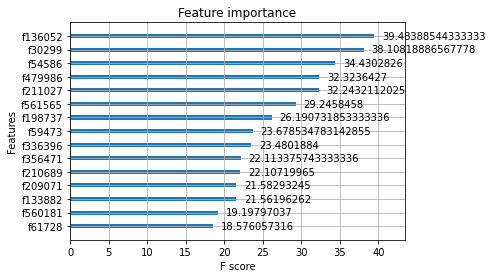

In [8]:
from xgboost import plot_importance
from matplotlib import pyplot
#best_model = pickle.load(open("FC_kfold_10_tt_from_all.pickle.dat", "rb"))
plt.figure(figsize = (20, 20))
plot_importance(best_model, max_num_features=15, importance_type='gain', height=0.3)
pyplot.show()

In [20]:
#This function essentially returns an array of dataframe headers the length of OHE'd input SNPs for training data
#EG. It will be able to determine that feature 357310 is Gm13_17683957 but not what allele it is
#eg. feature 357309 357310 and 357311 may all be one hot encoded versions of all possible values of Gm13_17683957
#iterating through the saved OHE will by able to determine what specific allele the feature is but cannot determine
#what SNP header it belongs to. Therefore combining these two methods you can determine both allele and SNP
snp = []
imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
fs_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
x = 0
n_headers = []
le = LabelEncoder()
#while (i < 10):
for chunk in pd.read_csv("PoC_Merged_filtered.csv_train_testQTL_SNPS.csv", chunksize=10000, index_col="Unnamed: 0"):
    chunk = chunk.T
    if 'Value' in chunk.columns:
        print("dropping value so it doesn't include that in headers")
        chunk = chunk.drop(columns=['Value'])
    headers = chunk.columns
    row_idx = chunk.index
    chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
    #since imputing makes a numpy array have to turn back into PD for label encoding
    chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
    chunk = chunk.apply(lambda col: le.fit_transform(col))
    c_headers = chunk.columns
    y = 0
    for column in chunk:
        d = (chunk[column].nunique())
        n_headers.extend([c_headers[y] for i in range(d)])
        #print(n_headers)
        #print(l)
        #n_headers.append(c_headers[y] * d)
        #print(n_headers)
        y = y + 1
    #to double check that it would indeed be one hot encoded with this amount of columns
    chunk = fs_ohe.fit_transform(chunk)
    x = x + chunk.shape[1]
    print("my X value is: " + str(x))
    print(chunk.shape)
    print("my header list is: " + str(len(n_headers)))
print(len(n_headers))

my X value is: 28943
(617, 28943)
my header list is: 28943
my X value is: 57392
(617, 28449)
my header list is: 57392
my X value is: 86590
(617, 29198)
my header list is: 86590
my X value is: 116146
(617, 29556)
my header list is: 116146
my X value is: 145140
(617, 28994)
my header list is: 145140
dropping value so it doesn't include that in headers
my X value is: 170396
(617, 25256)
my header list is: 170396
170396


Gm05_11968079 (A/A)
Gm01_55053811 (T/T)
Gm02_41961414 (A/A)
Gm17_6746570 (C/C)
Gm08_183702 (G/G)
Gm19_6434610 (A/A)
Gm07_17356456 (A/A)
Gm02_49207571 (C/C)
Gm12_18950685 (A/A)
Gm13_16076593 (G/G)
Gm07_45624847 (C/C)
Gm07_42559917 (T/T)
Gm05_6303805 (A/A)
Gm19_4824644 (A/A)
Gm03_642218 (C/C)
15
15


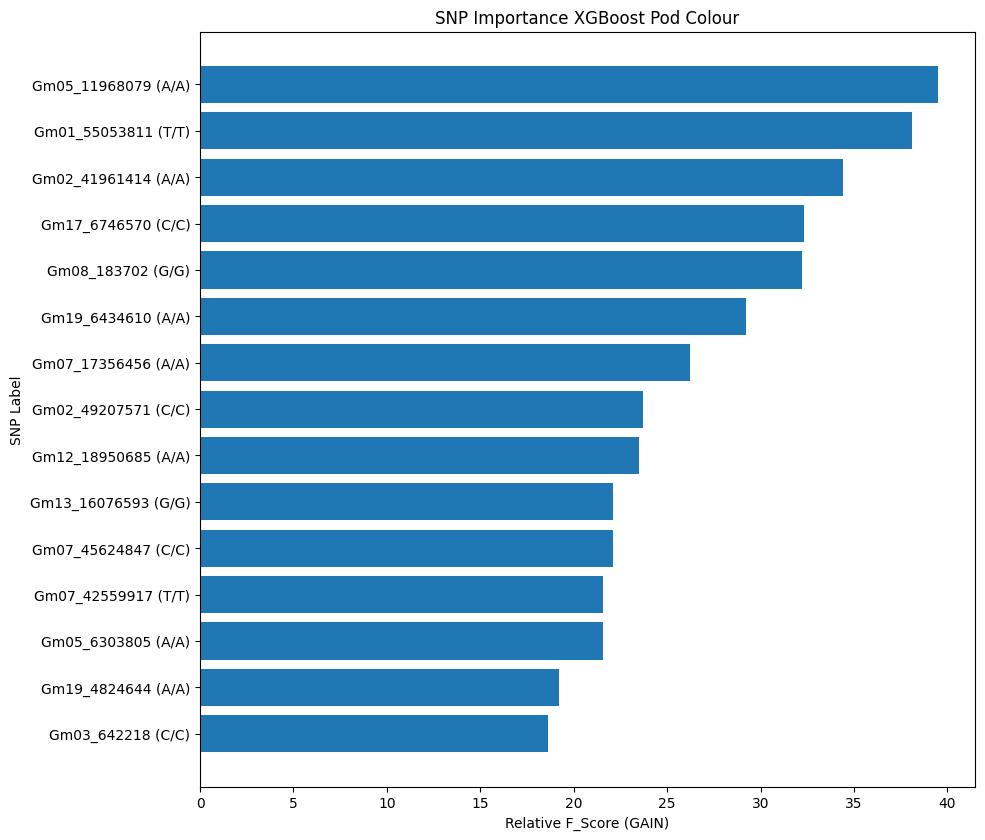

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
fs = [136052,30299,54586,479986,211027,561565,198737,59473,336396,356471,210689,209071,133882,560181,61728]
scores = [39.5,38.1,34.4,32.3,32.2,29.2,26.2,23.7,23.5,22.113,22.107,21.58,21.56,19.2,18.6]
snp_label = []
for jj in fs:
    jj_allele = find_snp_from_header(ohe, jj)
    this_snp = (n_headers[jj] + ' ('+str(jj_allele)+')')
    print(this_snp)
    snp_label.append(this_snp)
snp_label.reverse()
scores.reverse()
print(len(scores))
print(len(snp_label))
plt.barh(snp_label,scores)
plt.title('SNP Importance XGBoost Pod Colour')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

In [21]:
my_dict = best_model.get_booster().get_score(importance_type="gain")

In [22]:
def rename_f_header(fn,n_headers,ohe):
    fn = fn[1:]
    fn = int(fn)
    allele = find_snp_from_header(ohe, fn)
    this_snp = (n_headers[fn] + ' ('+str(allele)+')')
    return this_snp

In [23]:
#convert feature to actual SNP name
i = 0
new_dict = {}
for key in my_dict:
    new_key = rename_f_header(key, n_headers, ohe)
    new_dict[new_key] = my_dict[key]
    i = i + 1
    print(str(i))
    if(my_dict):
        continue
    else:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [24]:
new_fi = pd.Series(new_dict)
print(new_fi)
df = new_fi.to_frame()
df = df.rename(columns = {0:'F_Score(GAIN)'})
print(df)

Gm03_642300 (T/T)      84.748451
Gm01_55047009 (A/A)    37.480871
Gm01_54543776 (C/C)     0.706393
Gm03_632020 (A/A)       5.790105
Gm07_45619468 (C/C)     8.493835
                         ...    
Gm02_41613819 (A/A)     0.044076
Gm07_42668674 (T/T)     0.053545
Gm19_39270651 (A/A)     0.059054
Gm02_42040940 (T/T)     0.029073
Gm03_749993 (G/G)       0.090292
Length: 1844, dtype: float64
                     F_Score(GAIN)
Gm03_642300 (T/T)        84.748451
Gm01_55047009 (A/A)      37.480871
Gm01_54543776 (C/C)       0.706393
Gm03_632020 (A/A)         5.790105
Gm07_45619468 (C/C)       8.493835
...                            ...
Gm02_41613819 (A/A)       0.044076
Gm07_42668674 (T/T)       0.053545
Gm19_39270651 (A/A)       0.059054
Gm02_42040940 (T/T)       0.029073
Gm03_749993 (G/G)         0.090292

[1844 rows x 1 columns]


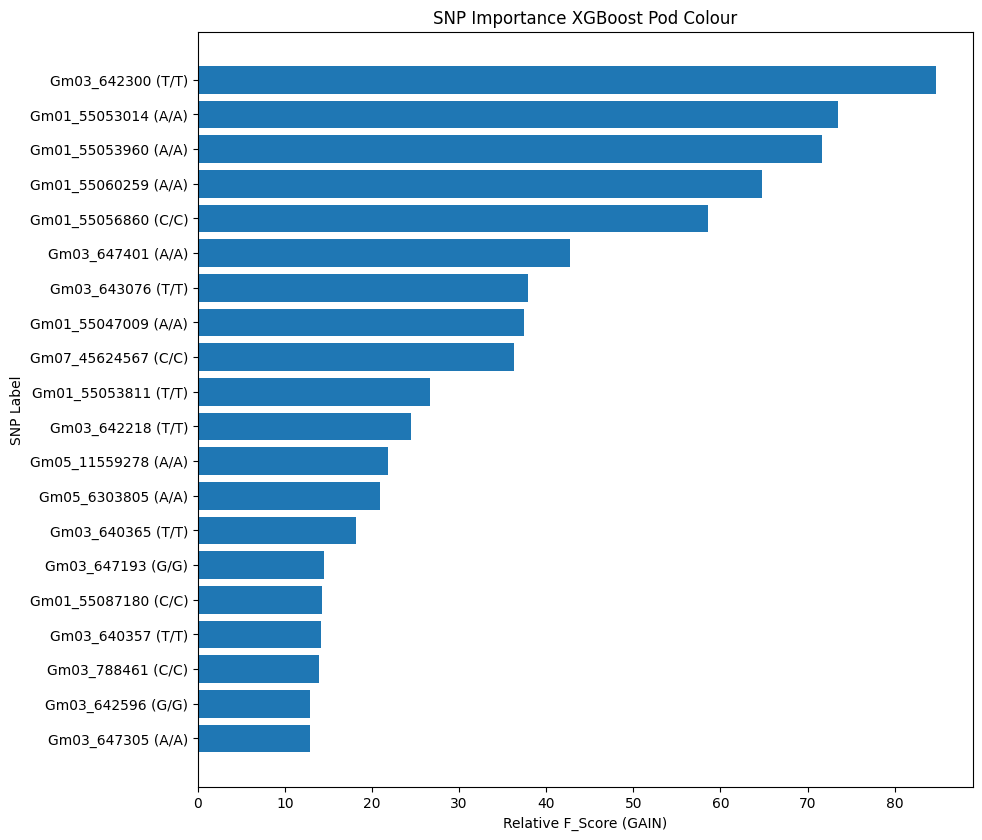

In [25]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
plt.barh(indexes, values)
plt.title('SNP Importance XGBoost Pod Colour')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

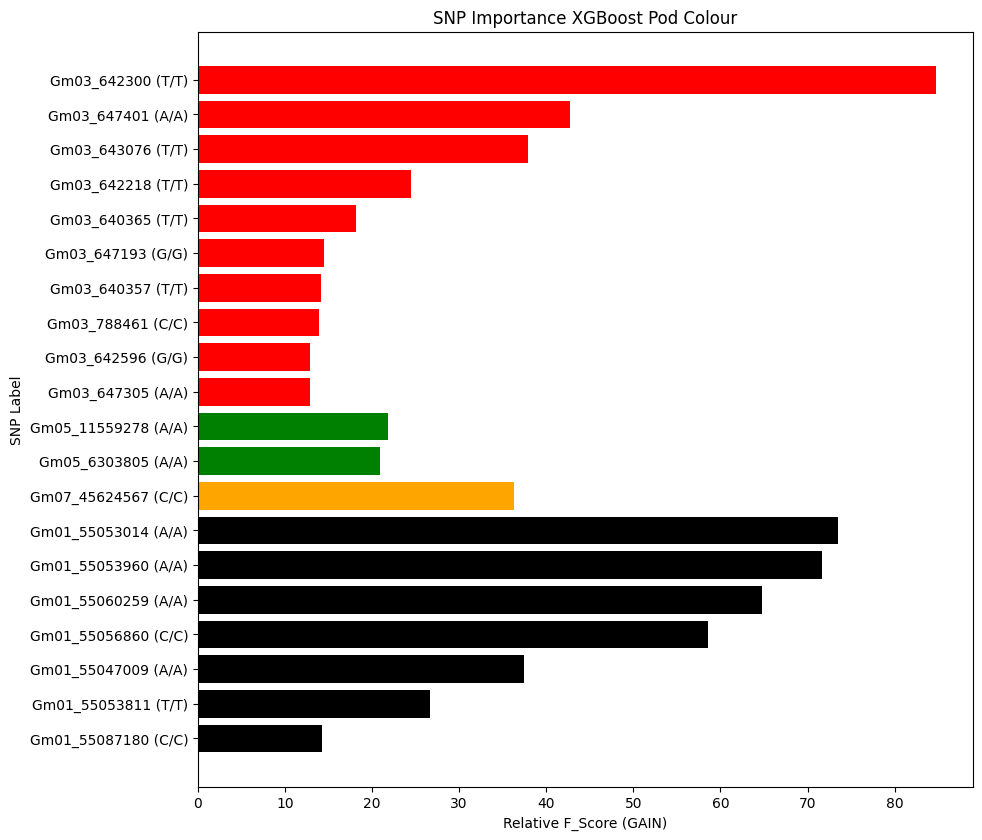

In [26]:
#generate figure object
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
#load in the 20 lardest values and their SNP label
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
#reverse to make the largest be at the front
indexes = indexes[::-1]
values = values[::-1]
#for each different chromosome you want to colour add a index(*_i) and value (*_v) array
#black would be colour for singular/notinteresting chromosomes
r_i = []
r_v = []
b_i = []
b_v = []
g_i = []
g_v = []
y_i = []
y_v = []
bl_i = []
bl_v = []
p_i = []
p_v = []
br_i = []
br_v = []
pu_i = []
pu_v = []
#for each value in the top n (default 20) check which chromosome it belongs to and add it to the colour array
i = 0
while i < len(indexes):
    if('Gm03' in indexes[i]):
        r_i.append(indexes[i])
        r_v.append(values[i])
    elif('Gm19' in indexes[i]):
        b_i.append(indexes[i])
        b_v.append(values[i])
    elif('Gm05' in indexes[i]):
        g_i.append(indexes[i])
        g_v.append(values[i])
    elif('Gm02' in indexes[i]):
        y_i.append(indexes[i])
        y_v.append(values[i])
    elif('Gm07' in indexes[i]):
        p_i.append(indexes[i])
        p_v.append(values[i])
   # elif('Gm04' in indexes[i]):
   #     br_i.append(indexes[i])
   #     br_v.append(values[i])
   # elif('Gm13' in indexes[i]):
   #     pu_i.append(indexes[i])
   #     pu_v.append(values[i])
    else:
        bl_i.append(indexes[i])
        bl_v.append(values[i])
    i = i + 1
#plot each of the arrays with appropriate colour and label graph
plt.barh(bl_i, bl_v, color="black")
plt.barh(br_i, br_v, color="brown")
plt.barh(pu_i, pu_v, color="purple")
plt.barh(y_i, y_v, color="yellow")
plt.barh(p_i, p_v, color="orange")
plt.barh(g_i, g_v, color="green")
plt.barh(r_i, r_v, color="red")
plt.barh(b_i, b_v, color="blue")
plt.title('SNP Importance XGBoost Pod Colour')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

# RL Model

In [28]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("PoC_Merged_filtered.csv_train_testQTL_SNPS.csv", "PoC_Merged_filtered.csv_holdoutQTL_SNPS.csv")
r_t = tt_pheno.ravel()
r_h = ho_pheno.ravel()
print(r_t[10])
i = 0
for x in r_t:
    if(x==0.5):
        r_t[i]=2.0
    i = i+1
i = 0
for x in r_h:
    if(x==0.5):
        r_h[i]=2.0
    i = i+1
r_t = np.reshape(r_t,(len(r_t),1))
r_h = np.reshape(r_h,(len(r_h),1))
tt_pheno = r_t
ho_pheno = r_h
print(tt_pheno.shape)
print(ho_pheno.shape)

10000
20000
30000
40000
50000
(617,)
(617, 1)
60000
10000
20000
30000
40000
50000
(155,)
(155, 1)
60000
(617, 58574)
(155, 58574)
(617, 1)
0.0
(617, 1)
(155, 1)


In [29]:
#if need or have new holdout data etc.
ohe = pickle.load(open("PoC_QTL_ohe.dat", "rb"))

In [30]:
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(617, 58574)
(617, 170396)
(155, 58574)
(155, 170396)


In [31]:
print(tt_vcf.shape)
print(tt_pheno.shape)
print(ho_vcf.shape)
print(ho_pheno.shape)
seed = randint(0,5000)
 #if optimised in same session, other enter manually below
#this function should average out 10 folds and training, with inital params optimised
#average accuracy and std should be calculated along with a nice AUROC graph of train/test models
#best model should be extracted for use on holdout set
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_features = 'sqrt',n_jobs=1, verbose = 1)
best_model = eval_k_fold(model, tt_vcf, tt_pheno, 10, ho_vcf, ho_pheno)

(617, 170396)
(617, 1)
(155, 170396)
(155, 1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is88.88888888888889


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is95.23809523809523


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is93.65079365079364


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is87.3015873015873


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is90.32258064516128


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is90.1639344262295


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is91.80327868852459


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is80.32786885245902


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is73.33333333333333


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is70.0
81.29032258064515
Training Testing Accuracy: 86.10% (8.20%)
Holdout Accuracy: 81.29%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


<Figure size 864x864 with 0 Axes>

# CNN (based off primer paper and Philipp)

In [5]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("PoC_Merged_filtered.csv_train_testQTL_SNPS.csv", "PoC_Merged_filtered.csv_holdoutQTL_SNPS.csv")
r_t = tt_pheno.ravel()
r_h = ho_pheno.ravel()
print(r_t[10])
i = 0
for x in r_t:
    if(x==0.5):
        r_t[i]=2.0
    i = i+1
i = 0
for x in r_h:
    if(x==0.5):
        r_h[i]=2.0
    i = i+1
r_t = np.reshape(r_t,(len(r_t),1))
r_h = np.reshape(r_h,(len(r_h),1))
tt_pheno = r_t
ho_pheno = r_h
print(tt_pheno.shape)
print(ho_pheno.shape)

10000
20000
30000
40000
50000
(617,)
(617, 1)
60000
10000
20000
30000
40000
50000
(155,)
(155, 1)
60000
(617, 58574)
(155, 58574)
(617, 1)
0.0
(617, 1)
(155, 1)


In [6]:
ohe = pickle.load(open("PoC_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(617, 170396)
(155, 58574)
(155, 170396)


In [7]:
##how to mlb both tt and ho for same scheme? do i even need to?

mlb = MultiLabelBinarizer()
mlb = mlb.fit(tt_pheno)
##print(tt_pheno.shape)
#print(ho_pheno.shape)
#tt_pheno = mlb.transform(tt_pheno)
#print(tt_pheno.shape)
#ho_pheno = mlb.transform(ho_pheno)
#print(ho_pheno.shape)

In [8]:
def build_CNN_model(x_len):    
    #del model
    model = Sequential()
    model.add(Conv1D(filters=10, kernel_size=10, 
                     input_shape=(x_len, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=8, kernel_size=8, 
                     input_shape=(10, 1)))
    model.add(Activation('linear'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=6, kernel_size=6, 
                     input_shape=(8, 1)))
    model.add(Activation('linear'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(24, activation='linear'))
    model.add(Dense(16, activation='linear'))
    model.add(Dense(8, activation='linear'))
    model.add(BatchNormalization())
    model.add(Dense(3, activation='softmax'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    print(model.summary())
    return model

In [9]:
def eval_cnn(x,y,k,mlb):
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    best_model = []
    results = []
    highest = 0
    i = 1
    for train,test in cv.split(x,y):
        print(y.shape)
        print(y[train])
        if(i==1):
            y = mlb.transform(y)
            print(y.shape)
            print(y[train])
        x = x.reshape(x.shape[0], x.shape[1], 1)
        model = build_CNN_model(x[train].shape[1])
        bs = ((x[train].shape[0])/20)
        bs = round(bs)
        history = model.fit(x[train], y[train], validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        _, accuracy = model.evaluate(x[test], y[test], batch_size=bs, verbose=0)
        accuracy = accuracy *100
        print("accuracy for model " + str(i) + " is " + str(accuracy))
        if(accuracy > highest):
            highest = accuracy
            best_model = model
        results.append(accuracy)
        del model
        i = i + 1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results))) 
    return best_model

In [10]:
best_CNN = eval_cnn(tt_vcf, tt_pheno, 10, mlb)

(617, 1)
[[1.]
 [1.]
 [2.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [1.]
 [0.]
 [0.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 

554/554 [==============================] - 2s 3ms/sample - loss: 0.0987 - accuracy: 0.9910 - val_loss: 2.6283 - val_accuracy: 0.1746
Epoch 17/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.0944 - accuracy: 0.9892 - val_loss: 1.6928 - val_accuracy: 0.1746
Epoch 18/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0847 - accuracy: 0.9892 - val_loss: 1.5458 - val_accuracy: 0.1746
Epoch 19/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0807 - accuracy: 0.9910 - val_loss: 1.3906 - val_accuracy: 0.1746
Epoch 20/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.0899 - accuracy: 0.9856 - val_loss: 1.2371 - val_accuracy: 0.3175
Epoch 21/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.0782 - accuracy: 0.9910 - val_loss: 0.6389 - val_accuracy: 0.8571
Epoch 22/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.0528 - accuracy: 0.9982 - val_loss: 0.9566 - val_accuracy

554/554 [==============================] - 2s 3ms/sample - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.8415 - val_accuracy: 0.8571
Epoch 73/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.7816 - val_accuracy: 0.8730
Epoch 74/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.8144 - val_accuracy: 0.8571
Epoch 75/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.8143 - val_accuracy: 0.8571
Epoch 76/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.7759 - val_accuracy: 0.8730
Epoch 77/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.8687 - val_accuracy: 0.8571
Epoch 78/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.8870 - val_accuracy

554/554 [==============================] - 1s 3ms/sample - loss: 0.2625 - accuracy: 0.9224 - val_loss: 2.2144 - val_accuracy: 0.1746
Epoch 11/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.1923 - accuracy: 0.9675 - val_loss: 2.1811 - val_accuracy: 0.1746
Epoch 12/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.1706 - accuracy: 0.9603 - val_loss: 1.9184 - val_accuracy: 0.1746
Epoch 13/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.1654 - accuracy: 0.9639 - val_loss: 1.6050 - val_accuracy: 0.1746
Epoch 14/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.1220 - accuracy: 0.9856 - val_loss: 1.6356 - val_accuracy: 0.2063
Epoch 15/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.1361 - accuracy: 0.9747 - val_loss: 1.6114 - val_accuracy: 0.1905
Epoch 16/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.1093 - accuracy: 0.9765 - val_loss: 1.1331 - val_accuracy

554/554 [==============================] - 2s 3ms/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.4491 - val_accuracy: 0.8254
Epoch 67/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.4621 - val_accuracy: 0.8413
Epoch 68/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.5073 - val_accuracy: 0.8095
Epoch 69/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.4767 - val_accuracy: 0.8571
Epoch 70/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.4924 - val_accuracy: 0.8889
Epoch 71/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.4940 - val_accuracy: 0.8571
Epoch 72/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.4682 - val_accuracy

554/554 [==============================] - 2s 3ms/sample - loss: 0.6289 - accuracy: 0.7888 - val_loss: 1.6244 - val_accuracy: 0.1746
Epoch 5/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.5437 - accuracy: 0.8303 - val_loss: 1.8733 - val_accuracy: 0.1746
Epoch 6/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.4510 - accuracy: 0.8773 - val_loss: 2.0833 - val_accuracy: 0.1746
Epoch 7/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.3844 - accuracy: 0.8953 - val_loss: 2.2267 - val_accuracy: 0.1746
Epoch 8/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.3263 - accuracy: 0.9206 - val_loss: 2.3500 - val_accuracy: 0.1746
Epoch 9/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.2472 - accuracy: 0.9549 - val_loss: 2.4160 - val_accuracy: 0.1746
Epoch 10/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.1902 - accuracy: 0.9783 - val_loss: 2.0117 - val_accuracy: 0.1

554/554 [==============================] - 2s 3ms/sample - loss: 0.0440 - accuracy: 0.9892 - val_loss: 0.4525 - val_accuracy: 0.9048
Epoch 61/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0196 - accuracy: 0.9982 - val_loss: 0.6240 - val_accuracy: 0.8889
Epoch 62/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.4471 - val_accuracy: 0.9048
Epoch 63/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.4764 - val_accuracy: 0.9048
Epoch 64/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.3705 - val_accuracy: 0.9048
Epoch 65/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.3442 - val_accuracy: 0.9206
Epoch 66/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.3752 - val_accuracy

Train on 554 samples, validate on 63 samples
Epoch 1/100
554/554 [==============================] - 2s 4ms/sample - loss: 0.8752 - accuracy: 0.6209 - val_loss: 0.6693 - val_accuracy: 0.7778
Epoch 2/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.7423 - accuracy: 0.7256 - val_loss: 1.0027 - val_accuracy: 0.2063
Epoch 3/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.6607 - accuracy: 0.7545 - val_loss: 1.2951 - val_accuracy: 0.1746
Epoch 4/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.6134 - accuracy: 0.7744 - val_loss: 1.5146 - val_accuracy: 0.1746
Epoch 5/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.5300 - accuracy: 0.8213 - val_loss: 1.7681 - val_accuracy: 0.1746
Epoch 6/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.4353 - accuracy: 0.8682 - val_loss: 1.8989 - val_accuracy: 0.1746
Epoch 7/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.3806 -

Epoch 57/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.3992 - val_accuracy: 0.9206
Epoch 58/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3771 - val_accuracy: 0.8889
Epoch 59/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.4175 - val_accuracy: 0.8413
Epoch 60/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.4573 - val_accuracy: 0.9048
Epoch 61/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.4701 - val_accuracy: 0.8413
Epoch 62/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.3642 - val_accuracy: 0.9206
Epoch 63/100
554/554 [==============================] - 1s 3ms/sample - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.4844 -

Train on 555 samples, validate on 62 samples
Epoch 1/100
555/555 [==============================] - 3s 5ms/sample - loss: 0.9246 - accuracy: 0.6324 - val_loss: 0.7795 - val_accuracy: 0.6774
Epoch 2/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.8034 - accuracy: 0.6865 - val_loss: 1.1811 - val_accuracy: 0.1774
Epoch 3/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.7251 - accuracy: 0.6991 - val_loss: 1.5325 - val_accuracy: 0.1774
Epoch 4/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.6333 - accuracy: 0.7477 - val_loss: 1.8613 - val_accuracy: 0.1774
Epoch 5/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.5460 - accuracy: 0.8162 - val_loss: 2.1020 - val_accuracy: 0.1774
Epoch 6/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.4557 - accuracy: 0.8324 - val_loss: 2.4015 - val_accuracy: 0.1774
Epoch 7/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.3585 -

Epoch 57/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2342 - val_accuracy: 0.8871
Epoch 58/100
555/555 [==============================] - 1s 3ms/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2342 - val_accuracy: 0.9032
Epoch 59/100
555/555 [==============================] - 1s 3ms/sample - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.2387 - val_accuracy: 0.9194
Epoch 60/100
555/555 [==============================] - 1s 3ms/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2340 - val_accuracy: 0.8871
Epoch 61/100
555/555 [==============================] - 1s 3ms/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2791 - val_accuracy: 0.8871
Epoch 62/100
555/555 [==============================] - 1s 3ms/sample - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.2262 - val_accuracy: 0.9194
Epoch 63/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2476 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 3s 6ms/sample - loss: 1.0447 - accuracy: 0.5396 - val_loss: 0.5638 - val_accuracy: 0.7869
Epoch 2/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.7322 - accuracy: 0.6709 - val_loss: 0.7220 - val_accuracy: 0.7869
Epoch 3/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6691 - accuracy: 0.7266 - val_loss: 1.0117 - val_accuracy: 0.3443
Epoch 4/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.5951 - accuracy: 0.7698 - val_loss: 1.2652 - val_accuracy: 0.1967
Epoch 5/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.5189 - accuracy: 0.8273 - val_loss: 1.7666 - val_accuracy: 0.1803
Epoch 6/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.4219 - accuracy: 0.8741 - val_loss: 1.2259 - val_accuracy: 0.2131
Epoch 7/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.3399 -

Epoch 57/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.4509 - val_accuracy: 0.8361
Epoch 58/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.4495 - val_accuracy: 0.8361
Epoch 59/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.4331 - val_accuracy: 0.8689
Epoch 60/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.4063 - val_accuracy: 0.8361
Epoch 61/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.4642 - val_accuracy: 0.8361
Epoch 62/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.4461 - val_accuracy: 0.9016
Epoch 63/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.3882 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 6s 11ms/sample - loss: 0.8386 - accuracy: 0.6673 - val_loss: 0.5718 - val_accuracy: 0.7869
Epoch 2/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.7090 - accuracy: 0.7086 - val_loss: 1.0053 - val_accuracy: 0.4098
Epoch 3/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.7024 - accuracy: 0.7212 - val_loss: 1.5012 - val_accuracy: 0.2787
Epoch 4/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6126 - accuracy: 0.7752 - val_loss: 2.0523 - val_accuracy: 0.1803
Epoch 5/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.5571 - accuracy: 0.8058 - val_loss: 2.3340 - val_accuracy: 0.1803
Epoch 6/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.4690 - accuracy: 0.8435 - val_loss: 2.6125 - val_accuracy: 0.1803
Epoch 7/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.4004 

Epoch 57/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.3912 - val_accuracy: 0.9180
Epoch 58/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.3783 - val_accuracy: 0.9016
Epoch 59/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.3931 - val_accuracy: 0.9180
Epoch 60/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3778 - val_accuracy: 0.9180
Epoch 61/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.3442 - val_accuracy: 0.9016
Epoch 62/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.3915 - val_accuracy: 0.9016
Epoch 63/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.3915 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 2s 4ms/sample - loss: 0.8462 - accuracy: 0.6223 - val_loss: 0.7968 - val_accuracy: 0.6557
Epoch 2/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.7054 - accuracy: 0.7392 - val_loss: 1.1800 - val_accuracy: 0.1803
Epoch 3/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6830 - accuracy: 0.7284 - val_loss: 1.7083 - val_accuracy: 0.1803
Epoch 4/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6324 - accuracy: 0.7446 - val_loss: 2.0543 - val_accuracy: 0.1803
Epoch 5/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6059 - accuracy: 0.7680 - val_loss: 2.3167 - val_accuracy: 0.1803
Epoch 6/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.5229 - accuracy: 0.8112 - val_loss: 2.7211 - val_accuracy: 0.1803
Epoch 7/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.3949 -

Epoch 57/100
556/556 [==============================] - 1s 3ms/sample - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.7481 - val_accuracy: 0.8197
Epoch 58/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.6508 - val_accuracy: 0.7705
Epoch 59/100
556/556 [==============================] - 1s 3ms/sample - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.6541 - val_accuracy: 0.7705
Epoch 60/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.6682 - val_accuracy: 0.7705
Epoch 61/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.7889 - val_accuracy: 0.8197
Epoch 62/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.6125 - val_accuracy: 0.7869
Epoch 63/100
556/556 [==============================] - 1s 3ms/sample - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.7015 -

Train on 557 samples, validate on 60 samples
Epoch 1/100
557/557 [==============================] - 3s 5ms/sample - loss: 0.7889 - accuracy: 0.6750 - val_loss: 0.9108 - val_accuracy: 0.6500
Epoch 2/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.6747 - accuracy: 0.7271 - val_loss: 1.3719 - val_accuracy: 0.1833
Epoch 3/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.5979 - accuracy: 0.7666 - val_loss: 1.7466 - val_accuracy: 0.1667
Epoch 4/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.5535 - accuracy: 0.8043 - val_loss: 1.8820 - val_accuracy: 0.1667
Epoch 5/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.4521 - accuracy: 0.8618 - val_loss: 2.2036 - val_accuracy: 0.1667
Epoch 6/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.4134 - accuracy: 0.8654 - val_loss: 2.4063 - val_accuracy: 0.1667
Epoch 7/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.3363 -

Epoch 57/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.9936 - val_accuracy: 0.7667
Epoch 58/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.2092 - val_accuracy: 0.7167
Epoch 59/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.0898 - val_accuracy: 0.7333
Epoch 60/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.0171 - val_accuracy: 0.7667
Epoch 61/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.1329 - val_accuracy: 0.7500
Epoch 62/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.4529 - val_accuracy: 0.7000
Epoch 63/100
557/557 [==============================] - 1s 3ms/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.0949 -

Train on 557 samples, validate on 60 samples
Epoch 1/100
557/557 [==============================] - 2s 4ms/sample - loss: 0.8527 - accuracy: 0.6014 - val_loss: 1.0551 - val_accuracy: 0.5500
Epoch 2/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.6775 - accuracy: 0.7110 - val_loss: 1.5029 - val_accuracy: 0.1667
Epoch 3/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.6457 - accuracy: 0.7253 - val_loss: 2.1507 - val_accuracy: 0.1667
Epoch 4/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.6045 - accuracy: 0.7558 - val_loss: 2.8803 - val_accuracy: 0.1667
Epoch 5/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.5274 - accuracy: 0.7953 - val_loss: 3.8869 - val_accuracy: 0.1667
Epoch 6/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.4955 - accuracy: 0.8276 - val_loss: 3.7879 - val_accuracy: 0.1667
Epoch 7/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.3616 -

Epoch 57/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3843 - val_accuracy: 0.7667
Epoch 58/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0163 - accuracy: 0.9982 - val_loss: 2.1556 - val_accuracy: 0.7167
Epoch 59/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0070 - accuracy: 1.0000 - val_loss: 1.4926 - val_accuracy: 0.7333
Epoch 60/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0121 - accuracy: 0.9982 - val_loss: 1.2988 - val_accuracy: 0.7667
Epoch 61/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0061 - accuracy: 1.0000 - val_loss: 1.4231 - val_accuracy: 0.7167
Epoch 62/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.5270 - val_accuracy: 0.7667
Epoch 63/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3631 -

In [17]:
import pickle
pickle.dump(best_CNN, open("PoC_CNN_model.pickle.dat", "wb"))

TypeError: can't pickle _thread.RLock objects

In [11]:
bs = ((ho_vcf.shape[0])/40)
bs = round(bs)
ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1],1)
ho_pheno = mlb.transform(ho_pheno)
_, accuracy = best_CNN.evaluate(ho_vcf, ho_pheno, batch_size=bs, verbose=0)
print("Holdout accuracy is " + str(accuracy*100))

Holdout accuracy is 71.61290049552917


# DNN (based off yield prediction paper)

In [13]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("PoC_Merged_filtered.csv_train_testQTL_SNPS.csv", "PoC_Merged_filtered.csv_holdoutQTL_SNPS.csv")
r_t = tt_pheno.ravel()
r_h = ho_pheno.ravel()
print(r_t[10])
i = 0
for x in r_t:
    if(x==0.5):
        r_t[i]=2.0
    i = i+1
i = 0
for x in r_h:
    if(x==0.5):
        r_h[i]=2.0
    i = i+1
r_t = np.reshape(r_t,(len(r_t),1))
r_h = np.reshape(r_h,(len(r_h),1))
tt_pheno = r_t
ho_pheno = r_h
print(tt_pheno.shape)
print(ho_pheno.shape)

10000
20000
30000
40000
50000
(617,)
(617, 1)
60000
10000
20000
30000
40000
50000
(155,)
(155, 1)
60000
(617, 58574)
(155, 58574)
(617, 1)
0.0
(617, 1)
(155, 1)


In [14]:
ohe = pickle.load(open("PoC_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(617, 170396)
(155, 58574)
(155, 170396)


In [15]:
##how to mlb both tt and ho for same scheme? do i even need to?

mlb = MultiLabelBinarizer()
mlb = mlb.fit(tt_pheno)
##print(tt_pheno.shape)
#print(ho_pheno.shape)
#tt_pheno = mlb.transform(tt_pheno)
#print(tt_pheno.shape)
#ho_pheno = mlb.transform(ho_pheno)
#print(ho_pheno.shape)

In [16]:
#My own DNN model based upon paper
#del model #incase its stored a previous model
#del history #for redoing shit

#do batch size as 64
#reduce the inputs by half when you read it in
#add XGboost and RF to the one notebook
def build_DNN_model(x_len):
    model = Sequential()

    #add first input layer, with no normalization
    model.add(Dense(192, input_dim = x_len))
    model.add(Activation('relu'))
    model.add(Dropout(0.03))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.02))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.01))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    #add output layer
    model.add(Dense(3, activation='softmax'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    print(model.summary())
    return model

In [17]:
def eval_dnn(x,y,k,mlb):
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    best_model = []
    results = []
    highest = 0
    i = 1
    for train,test in cv.split(x,y):
        print(y.shape)
        print(y[train])
        if(i==1):
            y = mlb.transform(y)
            print(y.shape)
            print(y[train])
        model = build_DNN_model(x[train].shape[1])
        bs = ((x[train].shape[0])/20)
        bs = round(bs)
        history = model.fit(x[train], y[train], validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        _, accuracy = model.evaluate(x[test], y[test], batch_size=bs, verbose=0)
        accuracy = accuracy *100
        print("accuracy for model " + str(i) + " is " + str(accuracy))
        if(accuracy > highest):
            highest = accuracy
            best_model = model
        results.append(accuracy)
        del model
        i = i + 1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results))) 
    return best_model

In [18]:
best_DNN = eval_dnn(tt_vcf, tt_pheno, 10, mlb)

(617, 1)
[[1.]
 [1.]
 [2.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [1.]
 [0.]
 [0.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 

554/554 [==============================] - 1s 1ms/sample - loss: 0.2135 - accuracy: 0.9242 - val_loss: 0.7260 - val_accuracy: 0.8571
Epoch 18/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.1621 - accuracy: 0.9458 - val_loss: 0.7847 - val_accuracy: 0.8254
Epoch 19/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.1620 - accuracy: 0.9440 - val_loss: 0.6953 - val_accuracy: 0.8254
Epoch 20/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.1234 - accuracy: 0.9603 - val_loss: 0.7783 - val_accuracy: 0.8254
Epoch 21/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.1182 - accuracy: 0.9549 - val_loss: 0.6449 - val_accuracy: 0.8413
Epoch 22/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.1069 - accuracy: 0.9693 - val_loss: 1.1012 - val_accuracy: 0.8095
Epoch 23/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0994 - accuracy: 0.9639 - val_loss: 1.0744 - val_accuracy

554/554 [==============================] - 1s 1ms/sample - loss: 0.0075 - accuracy: 0.9964 - val_loss: 1.1721 - val_accuracy: 0.8571
Epoch 74/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0209 - accuracy: 0.9910 - val_loss: 1.0755 - val_accuracy: 0.8254
Epoch 75/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0093 - accuracy: 0.9982 - val_loss: 1.1184 - val_accuracy: 0.8413
Epoch 76/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0137 - accuracy: 0.9928 - val_loss: 1.0072 - val_accuracy: 0.8571
Epoch 77/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0087 - accuracy: 0.9982 - val_loss: 0.9741 - val_accuracy: 0.8730
Epoch 78/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.0355 - val_accuracy: 0.8571
Epoch 79/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.0944 - val_accuracy

554/554 [==============================] - 1s 1ms/sample - loss: 0.3921 - accuracy: 0.8574 - val_loss: 0.5741 - val_accuracy: 0.8254
Epoch 13/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.3388 - accuracy: 0.8736 - val_loss: 0.8270 - val_accuracy: 0.7460
Epoch 14/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.3332 - accuracy: 0.8899 - val_loss: 0.7415 - val_accuracy: 0.7302
Epoch 15/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.2962 - accuracy: 0.8827 - val_loss: 0.8598 - val_accuracy: 0.7302
Epoch 16/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.2624 - accuracy: 0.8971 - val_loss: 0.6794 - val_accuracy: 0.8254
Epoch 17/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.2293 - accuracy: 0.9079 - val_loss: 0.6122 - val_accuracy: 0.7937
Epoch 18/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.2059 - accuracy: 0.9206 - val_loss: 0.6826 - val_accuracy

554/554 [==============================] - 1s 1ms/sample - loss: 0.0396 - accuracy: 0.9892 - val_loss: 1.4791 - val_accuracy: 0.7778
Epoch 69/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0139 - accuracy: 0.9964 - val_loss: 0.9876 - val_accuracy: 0.7778
Epoch 70/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0121 - accuracy: 1.0000 - val_loss: 1.1377 - val_accuracy: 0.8095
Epoch 71/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0236 - accuracy: 0.9928 - val_loss: 1.2135 - val_accuracy: 0.7937
Epoch 72/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0088 - accuracy: 0.9982 - val_loss: 1.0682 - val_accuracy: 0.8254
Epoch 73/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0211 - accuracy: 0.9928 - val_loss: 1.0544 - val_accuracy: 0.7619
Epoch 74/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0088 - accuracy: 0.9964 - val_loss: 1.0567 - val_accuracy

554/554 [==============================] - 1s 1ms/sample - loss: 0.6611 - accuracy: 0.7148 - val_loss: 0.4798 - val_accuracy: 0.7460
Epoch 8/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.6376 - accuracy: 0.7274 - val_loss: 0.4621 - val_accuracy: 0.7460
Epoch 9/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.5797 - accuracy: 0.7491 - val_loss: 0.4627 - val_accuracy: 0.8571
Epoch 10/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.5470 - accuracy: 0.7780 - val_loss: 0.5608 - val_accuracy: 0.8095
Epoch 11/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.5011 - accuracy: 0.7888 - val_loss: 0.5066 - val_accuracy: 0.7460
Epoch 12/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.4614 - accuracy: 0.8321 - val_loss: 1.5963 - val_accuracy: 0.3492
Epoch 13/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.3878 - accuracy: 0.8610 - val_loss: 0.3682 - val_accuracy: 

554/554 [==============================] - 1s 1ms/sample - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.5032 - val_accuracy: 0.9206
Epoch 64/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0101 - accuracy: 0.9982 - val_loss: 0.4437 - val_accuracy: 0.9048
Epoch 65/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0129 - accuracy: 0.9982 - val_loss: 0.4865 - val_accuracy: 0.8889
Epoch 66/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.7580 - val_accuracy: 0.8571
Epoch 67/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0140 - accuracy: 0.9946 - val_loss: 0.5362 - val_accuracy: 0.8889
Epoch 68/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0194 - accuracy: 0.9910 - val_loss: 0.7035 - val_accuracy: 0.8730
Epoch 69/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.4942 - val_accuracy

554/554 [==============================] - 1s 1ms/sample - loss: 0.7439 - accuracy: 0.6841 - val_loss: 1.0165 - val_accuracy: 0.7302
Epoch 3/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.7194 - accuracy: 0.6841 - val_loss: 1.0564 - val_accuracy: 0.7302
Epoch 4/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.6821 - accuracy: 0.7058 - val_loss: 0.8494 - val_accuracy: 0.7619
Epoch 5/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.6474 - accuracy: 0.7220 - val_loss: 0.3975 - val_accuracy: 0.7778
Epoch 6/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.6314 - accuracy: 0.7365 - val_loss: 0.4878 - val_accuracy: 0.7619
Epoch 7/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.5856 - accuracy: 0.7563 - val_loss: 0.4569 - val_accuracy: 0.7619
Epoch 8/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.5387 - accuracy: 0.7942 - val_loss: 0.4168 - val_accuracy: 0.85

554/554 [==============================] - 1s 1ms/sample - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.7253 - val_accuracy: 0.8095
Epoch 59/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0358 - accuracy: 0.9838 - val_loss: 0.5715 - val_accuracy: 0.8571
Epoch 60/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0436 - accuracy: 0.9819 - val_loss: 0.9355 - val_accuracy: 0.7778
Epoch 61/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0142 - accuracy: 0.9964 - val_loss: 0.7405 - val_accuracy: 0.8095
Epoch 62/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.4814 - val_accuracy: 0.8730
Epoch 63/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0364 - accuracy: 0.9928 - val_loss: 0.9668 - val_accuracy: 0.8095
Epoch 64/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.0899 - accuracy: 0.9783 - val_loss: 0.8820 - val_accuracy

Train on 555 samples, validate on 62 samples
Epoch 1/100
555/555 [==============================] - 2s 3ms/sample - loss: 1.0156 - accuracy: 0.5261 - val_loss: 2.5773 - val_accuracy: 0.7581
Epoch 2/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.8582 - accuracy: 0.6595 - val_loss: 1.7422 - val_accuracy: 0.7581
Epoch 3/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.7479 - accuracy: 0.6847 - val_loss: 2.0311 - val_accuracy: 0.7581
Epoch 4/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.7202 - accuracy: 0.6865 - val_loss: 1.4777 - val_accuracy: 0.7581
Epoch 5/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.6717 - accuracy: 0.7225 - val_loss: 1.2900 - val_accuracy: 0.7581
Epoch 6/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.6370 - accuracy: 0.7243 - val_loss: 0.6860 - val_accuracy: 0.7742
Epoch 7/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.6123 -

Epoch 57/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.0304 - accuracy: 0.9910 - val_loss: 0.5064 - val_accuracy: 0.8548
Epoch 58/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.0245 - accuracy: 0.9946 - val_loss: 0.4177 - val_accuracy: 0.8065
Epoch 59/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.0145 - accuracy: 0.9982 - val_loss: 0.6864 - val_accuracy: 0.8548
Epoch 60/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.6836 - val_accuracy: 0.8548
Epoch 61/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.0698 - accuracy: 0.9730 - val_loss: 0.5012 - val_accuracy: 0.8226
Epoch 62/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.0265 - accuracy: 0.9946 - val_loss: 0.9943 - val_accuracy: 0.8548
Epoch 63/100
555/555 [==============================] - 1s 1ms/sample - loss: 0.0208 - accuracy: 0.9964 - val_loss: 0.4431 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 1s 3ms/sample - loss: 0.8383 - accuracy: 0.6367 - val_loss: 3.1535 - val_accuracy: 0.4098
Epoch 2/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.7483 - accuracy: 0.6942 - val_loss: 0.6068 - val_accuracy: 0.5574
Epoch 3/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.7302 - accuracy: 0.6978 - val_loss: 1.5592 - val_accuracy: 0.4098
Epoch 4/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.6599 - accuracy: 0.7158 - val_loss: 1.5485 - val_accuracy: 0.4098
Epoch 5/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.6369 - accuracy: 0.7482 - val_loss: 0.4096 - val_accuracy: 0.8033
Epoch 6/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.6109 - accuracy: 0.7500 - val_loss: 0.3979 - val_accuracy: 0.8361
Epoch 7/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.5398 -

Epoch 57/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.7580 - val_accuracy: 0.8852
Epoch 58/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0154 - accuracy: 0.9946 - val_loss: 1.1869 - val_accuracy: 0.6557
Epoch 59/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0116 - accuracy: 0.9946 - val_loss: 0.7533 - val_accuracy: 0.8525
Epoch 60/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0080 - accuracy: 0.9982 - val_loss: 0.9876 - val_accuracy: 0.7541
Epoch 61/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.9202 - val_accuracy: 0.8689
Epoch 62/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.6966 - val_accuracy: 0.8361
Epoch 63/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.7529 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 1s 2ms/sample - loss: 0.9285 - accuracy: 0.5629 - val_loss: 4.2268 - val_accuracy: 0.5902
Epoch 2/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.7580 - accuracy: 0.7086 - val_loss: 1.8743 - val_accuracy: 0.7049
Epoch 3/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.6929 - accuracy: 0.7050 - val_loss: 1.7643 - val_accuracy: 0.7541
Epoch 4/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.6953 - accuracy: 0.7122 - val_loss: 1.3008 - val_accuracy: 0.7705
Epoch 5/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.6026 - accuracy: 0.7482 - val_loss: 0.8105 - val_accuracy: 0.7869
Epoch 6/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.5590 - accuracy: 0.7716 - val_loss: 0.8787 - val_accuracy: 0.7869
Epoch 7/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.5172 -

Epoch 57/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0349 - accuracy: 0.9820 - val_loss: 0.6987 - val_accuracy: 0.8525
Epoch 58/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0450 - accuracy: 0.9892 - val_loss: 0.6110 - val_accuracy: 0.8361
Epoch 59/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0320 - accuracy: 0.9928 - val_loss: 0.7654 - val_accuracy: 0.9180
Epoch 60/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0215 - accuracy: 0.9910 - val_loss: 0.7786 - val_accuracy: 0.8852
Epoch 61/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0123 - accuracy: 0.9964 - val_loss: 0.5142 - val_accuracy: 0.9344
Epoch 62/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0163 - accuracy: 0.9964 - val_loss: 0.4476 - val_accuracy: 0.9016
Epoch 63/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0130 - accuracy: 0.9946 - val_loss: 0.5971 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 1s 2ms/sample - loss: 0.8746 - accuracy: 0.6295 - val_loss: 3.2613 - val_accuracy: 0.6393
Epoch 2/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.7228 - accuracy: 0.7140 - val_loss: 3.6356 - val_accuracy: 0.6066
Epoch 3/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.6959 - accuracy: 0.7014 - val_loss: 1.6818 - val_accuracy: 0.6393
Epoch 4/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.6570 - accuracy: 0.7212 - val_loss: 1.2503 - val_accuracy: 0.6230
Epoch 5/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.6278 - accuracy: 0.7230 - val_loss: 0.7697 - val_accuracy: 0.6721
Epoch 6/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.5722 - accuracy: 0.7734 - val_loss: 0.7098 - val_accuracy: 0.7213
Epoch 7/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.5444 -

Epoch 57/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0288 - accuracy: 0.9910 - val_loss: 1.6770 - val_accuracy: 0.6557
Epoch 58/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0210 - accuracy: 0.9946 - val_loss: 1.2059 - val_accuracy: 0.8033
Epoch 59/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0061 - accuracy: 1.0000 - val_loss: 1.2236 - val_accuracy: 0.8197
Epoch 60/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0089 - accuracy: 0.9964 - val_loss: 1.1649 - val_accuracy: 0.8197
Epoch 61/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0201 - accuracy: 0.9946 - val_loss: 1.2407 - val_accuracy: 0.8033
Epoch 62/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0102 - accuracy: 0.9964 - val_loss: 0.9833 - val_accuracy: 0.7541
Epoch 63/100
556/556 [==============================] - 1s 1ms/sample - loss: 0.0161 - accuracy: 0.9964 - val_loss: 2.2549 -

Train on 557 samples, validate on 60 samples
Epoch 1/100
557/557 [==============================] - 1s 2ms/sample - loss: 0.8966 - accuracy: 0.5601 - val_loss: 7.1547 - val_accuracy: 0.6000
Epoch 2/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.7233 - accuracy: 0.6804 - val_loss: 4.5648 - val_accuracy: 0.6000
Epoch 3/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.6691 - accuracy: 0.7181 - val_loss: 3.3387 - val_accuracy: 0.6000
Epoch 4/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.6409 - accuracy: 0.7074 - val_loss: 2.9819 - val_accuracy: 0.6167
Epoch 5/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.6116 - accuracy: 0.7235 - val_loss: 1.5699 - val_accuracy: 0.6167
Epoch 6/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.5782 - accuracy: 0.7361 - val_loss: 1.1945 - val_accuracy: 0.6333
Epoch 7/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.5300 -

Epoch 57/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.8153 - val_accuracy: 0.7167
Epoch 58/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0101 - accuracy: 0.9964 - val_loss: 1.6516 - val_accuracy: 0.7167
Epoch 59/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0076 - accuracy: 0.9964 - val_loss: 1.7561 - val_accuracy: 0.7333
Epoch 60/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.8995 - val_accuracy: 0.7000
Epoch 61/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0112 - accuracy: 0.9964 - val_loss: 1.9256 - val_accuracy: 0.6833
Epoch 62/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0144 - accuracy: 0.9964 - val_loss: 2.7813 - val_accuracy: 0.6833
Epoch 63/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0112 - accuracy: 1.0000 - val_loss: 2.0564 -

Train on 557 samples, validate on 60 samples
Epoch 1/100
557/557 [==============================] - 1s 2ms/sample - loss: 0.9060 - accuracy: 0.6158 - val_loss: 6.5708 - val_accuracy: 0.6000
Epoch 2/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.7322 - accuracy: 0.7056 - val_loss: 4.6329 - val_accuracy: 0.6000
Epoch 3/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.6821 - accuracy: 0.7092 - val_loss: 2.8257 - val_accuracy: 0.6167
Epoch 4/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.6281 - accuracy: 0.7433 - val_loss: 2.0111 - val_accuracy: 0.6167
Epoch 5/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.6110 - accuracy: 0.7415 - val_loss: 1.6095 - val_accuracy: 0.6167
Epoch 6/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.5723 - accuracy: 0.7630 - val_loss: 1.3380 - val_accuracy: 0.6333
Epoch 7/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.5382 -

Epoch 57/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0180 - accuracy: 0.9964 - val_loss: 2.0739 - val_accuracy: 0.4667
Epoch 58/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0153 - accuracy: 0.9946 - val_loss: 2.0166 - val_accuracy: 0.6833
Epoch 59/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0221 - accuracy: 0.9946 - val_loss: 1.7937 - val_accuracy: 0.5833
Epoch 60/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0111 - accuracy: 0.9982 - val_loss: 1.7799 - val_accuracy: 0.7333
Epoch 61/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0063 - accuracy: 0.9982 - val_loss: 1.7867 - val_accuracy: 0.7167
Epoch 62/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0138 - accuracy: 0.9982 - val_loss: 1.5283 - val_accuracy: 0.7333
Epoch 63/100
557/557 [==============================] - 1s 1ms/sample - loss: 0.0120 - accuracy: 0.9964 - val_loss: 1.9146 -

In [10]:
import pickle
pickle.dump(best_DNN, open("PoC_DNN_model.pickle.dat", "wb"))

TypeError: can't pickle _thread.RLock objects

In [19]:
bs = ((ho_vcf.shape[0])/40)
bs = round(bs)
ho_pheno = mlb.transform(ho_pheno)
_, accuracy = best_DNN.evaluate(ho_vcf, ho_pheno, batch_size=bs, verbose=0)
print("Holdout accuracy is " + str(accuracy*100))

Holdout accuracy is 72.25806713104248
